In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left']
predictors = predictors.drop(['pitch_locx', 'pitch_locy', 'pitchHand_isRight', 'batSide_isRight'], axis=1)
predictors = predictors.join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

In [6]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=3)

In [7]:
def fit_save_model(model, output_model_name, X_train, y_train):
    '''Function that takes an instantiated model, fits training data, and saves the best model.
    Also returns the training history of the model'''
    
    # Designate saved model name
    checkpoint_path = 'model_final/%s.hdf5' %(output_model_name)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_best_only = True,
                                                     verbose=1)
    
    # fit the training data to the basic model
    training_history = model.fit(X_train,
                                 y_train,
                                 validation_split = 0.25,
                                 epochs = 25,
                                 callbacks = [early_stopping_monitor, cp_callback])
    
    return checkpoint_path, training_history

In [8]:
def train_hist_plot(training_history, figname):
    '''Function to plot training history statistics from a model'''
    _ = plt.figure(figsize=(15, 15))

    _ = plt.subplot(2, 1, 1)
    _ = plt.plot(training_history.history['categorical_accuracy'])
    _ = plt.plot(training_history.history['val_categorical_accuracy'])
    _ = plt.title('Model Accuracy')
    _ = plt.ylabel('Accuracy')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')

    _ = plt.subplot(2, 1, 2)
    _ = plt.plot(training_history.history['loss'])
    _ = plt.plot(training_history.history['val_loss'])
    _ = plt.title('Model Loss')
    _ = plt.ylabel('Loss')
    _ = plt.xlabel('Epoch')
    _ = plt.legend(['Train', 'Validation'], loc='upper left')
    
    save_path = 'model_final/%s.png' %(figname)
    _ = plt.savefig(save_path)

In [9]:
def model_metrics(model, test_pred, test_labels):
    '''This function will print the metrics and scores of a model on test data'''
    
    # Make predictions on the test data
    predictions = model.predict(test_pred)
    
    # Create a confusion matrix
    matrix = confusion_matrix(test_labels.values.argmax(axis=1), predictions.argmax(axis=1))
    print(matrix)
    
    # Calculate AUC score
    auc = roc_auc_score(test_labels, predictions)
    print('AUC:', auc)
    
    # Make predictions on the test set
    score, acc = model.evaluate(test_pred, test_labels)
    print('Test score:', score)
    print('Test accuracy:', acc)

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    calls, 
                                                    test_size = 0.25, 
                                                    stratify = calls,
                                                    random_state = 837)

In [11]:
# Create a StandardScaler object and fit_transform X_train data
scaler_calls = StandardScaler()

X_train_scaled = scaler_calls.fit_transform(X_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
# Transform X_test data
X_test_scaled = scaler_calls.transform(X_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


# model_calls_id

In "Machine_Learning_Models" notebook, we built a model that took pitch location, pitch type, pitch speed, count, inning, and player ID number to predict the probability of 6 outcomes: ball, called strike, swinging strike, foul ball, hit, and out. The model was a neural network with 3 hidden layers and 1 output layer. The goal of this notebook is to improve upon the results of that model by increasing the capacity and/or the activation functions. The metrics of that model were as follows:
+ Test Score: 0.3443
+ Test Accuracy: 0.5012
+ AUC: 0.7824

Like the other notebook, the models are going to start simple and increase until the gains/losses start diminishing.

## Base Model

In [13]:
# Instatiate a Sequential model
model_final_base = Sequential()

# Create a basic network
model_final_base.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final_base.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [14]:
base_checkpoint_path, base_history = fit_save_model(model_final_base, 'model_final_base', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3476 - categorical_accuracy: 0.4990 - val_loss: 0.3454 - val_categorical_accuracy: 0.5033

Epoch 00001: val_loss improved from inf to 0.34537, saving model to model_final/model_final_base.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 27s 22us/step - loss: 0.3453 - categorical_accuracy: 0.5007 - val_loss: 0.3451 - val_categorical_accuracy: 0.4993

Epoch 00002: val_loss improved from 0.34537 to 0.34509, saving model to model_final/model_final_base.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 27s 22us/step - loss: 0.3450 - categorical_accuracy: 0.5008 - val_loss: 0.3448 - val_categorical_accuracy: 0.5054

Epoch 00003: val_loss improved from 0.34509 to 0.34483, saving model to model_final/model_final_base.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 26s 22us/step - loss: 0.3448 - categoric

In [15]:
# Load best model to save training time
model_final_base = keras.models.load_model(base_checkpoint_path)

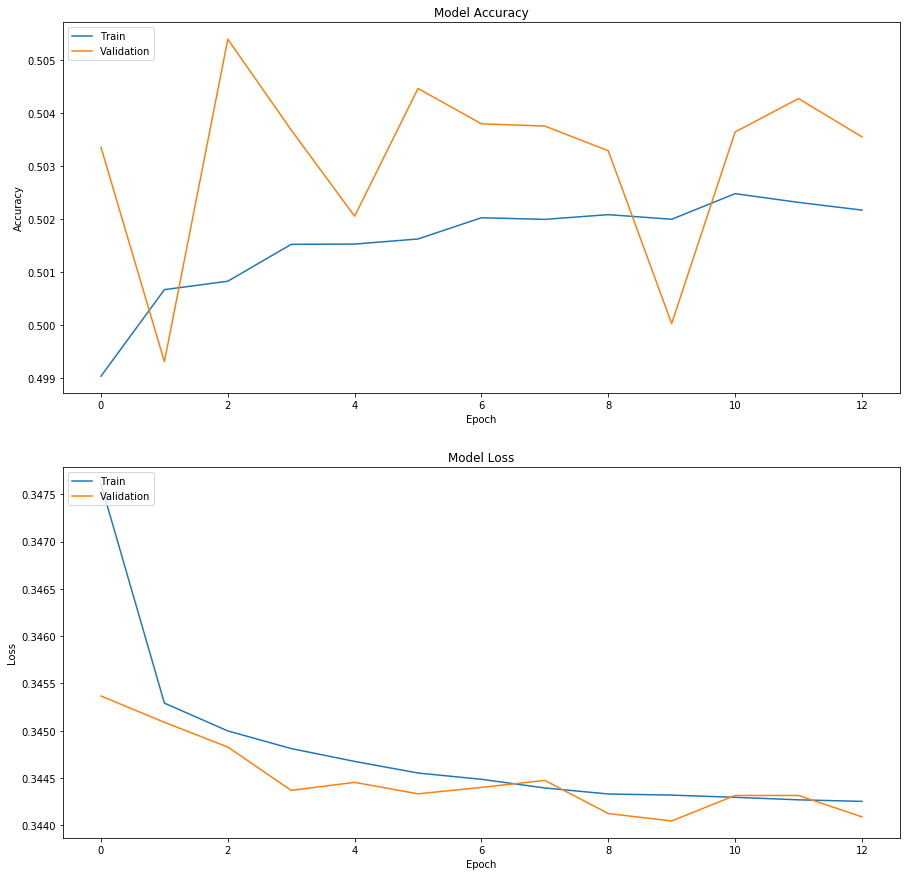

In [16]:
train_hist_plot(base_history, "model_final_base_train_perf")

In [17]:
model_metrics(model_final_base, X_test_scaled, y_test)

[[157074  20382   5175      0   2142   6951]
 [  7684  63446  10023      0   1705   6798]
 [ 17670  23903  21896      0   2633  26471]
 [  3897  10253   8007      0   1080  10918]
 [ 26798  11229   8969      0   3330  10660]
 [  9092  17460  14603      0   2159  19943]]
AUC: 0.7826919595788372
532351/532351 [==============================] - 4s 8us/step
Test score: 0.3443138178632648
Test accuracy: 0.4990861292651225


## Model 2

In [18]:
# Instatiate a Sequential model
model_final2 = Sequential()

# Create a basic network
model_final2.add(Dense(50, activation = 'tanh', input_shape = (X_train_scaled.shape[1],)))
model_final2.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [19]:
final2_checkpoint_path, final2_history = fit_save_model(model_final2, 'model_final2', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 28s 23us/step - loss: 0.3494 - categorical_accuracy: 0.4984 - val_loss: 0.3458 - val_categorical_accuracy: 0.5028

Epoch 00001: val_loss improved from inf to 0.34577, saving model to model_final/model_final2.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3455 - categorical_accuracy: 0.5006 - val_loss: 0.3454 - val_categorical_accuracy: 0.4964

Epoch 00002: val_loss improved from 0.34577 to 0.34542, saving model to model_final/model_final2.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3450 - categorical_accuracy: 0.5010 - val_loss: 0.3449 - val_categorical_accuracy: 0.4982

Epoch 00003: val_loss improved from 0.34542 to 0.34490, saving model to model_final/model_final2.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.3447 - categorical_accuracy:

In [20]:
# Load best model to save training time
model_final2 = keras.models.load_model(final2_checkpoint_path)

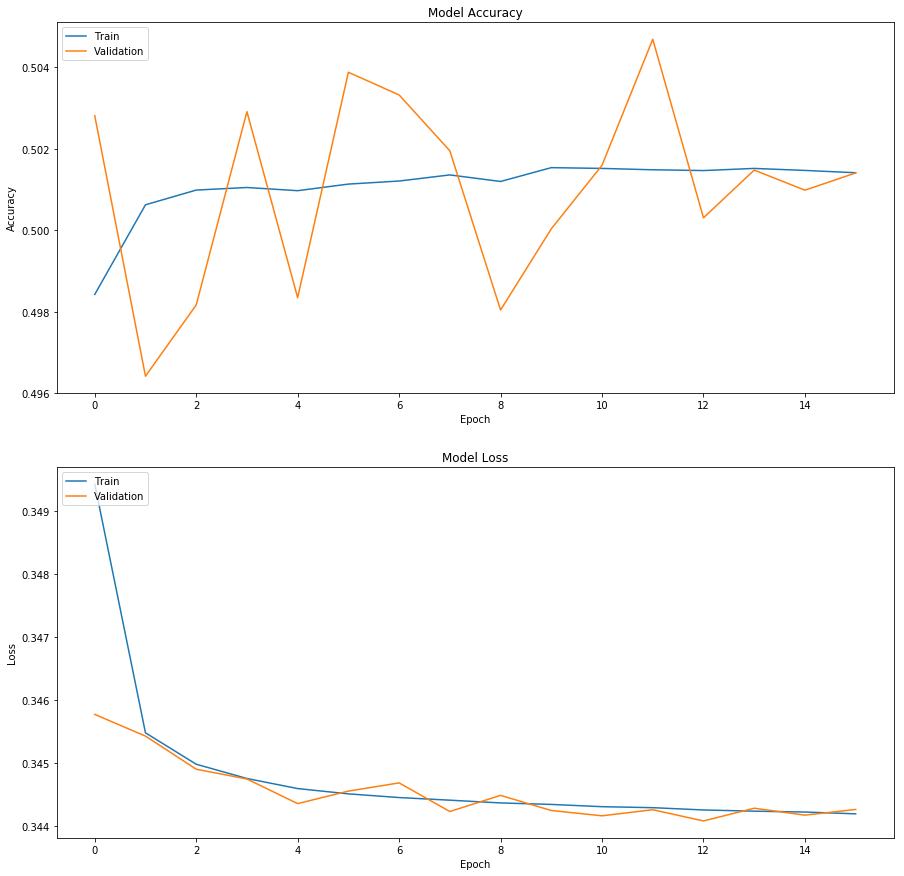

In [21]:
train_hist_plot(final2_history, "model_final2_train_perf")

In [22]:
model_metrics(model_final2, X_test_scaled, y_test)

[[157615  20685   5248      0    799   7377]
 [  7696  63827  10440      0    831   6862]
 [ 18367  23807  23587      0   1170  25642]
 [  4097  10332   8890      0    500  10336]
 [ 27679  11355   9918      0   1552  10482]
 [  9485  17626  15880      0    955  19311]]
AUC: 0.782578798193729
532351/532351 [==============================] - 5s 9us/step
Test score: 0.3442884097067264
Test accuracy: 0.4994674566207693


## Model 3

In [23]:
# Instatiate a Sequential model
model_final3 = Sequential()

# Create a basic network
model_final3.add(Dense(50, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final3.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [24]:
final3_checkpoint_path, final3_history = fit_save_model(model_final3, 'model_final3', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3498 - categorical_accuracy: 0.4981 - val_loss: 0.3468 - val_categorical_accuracy: 0.4979

Epoch 00001: val_loss improved from inf to 0.34683, saving model to model_final/model_final3.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3463 - categorical_accuracy: 0.5004 - val_loss: 0.3461 - val_categorical_accuracy: 0.5032

Epoch 00002: val_loss improved from 0.34683 to 0.34611, saving model to model_final/model_final3.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3458 - categorical_accuracy: 0.5006 - val_loss: 0.3459 - val_categorical_accuracy: 0.5024

Epoch 00003: val_loss improved from 0.34611 to 0.34586, saving model to model_final/model_final3.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 29s 24us/step - loss: 0.3456 - categorical_accuracy:

In [25]:
# Load best model to save training time
model_final3 = keras.models.load_model(final3_checkpoint_path)

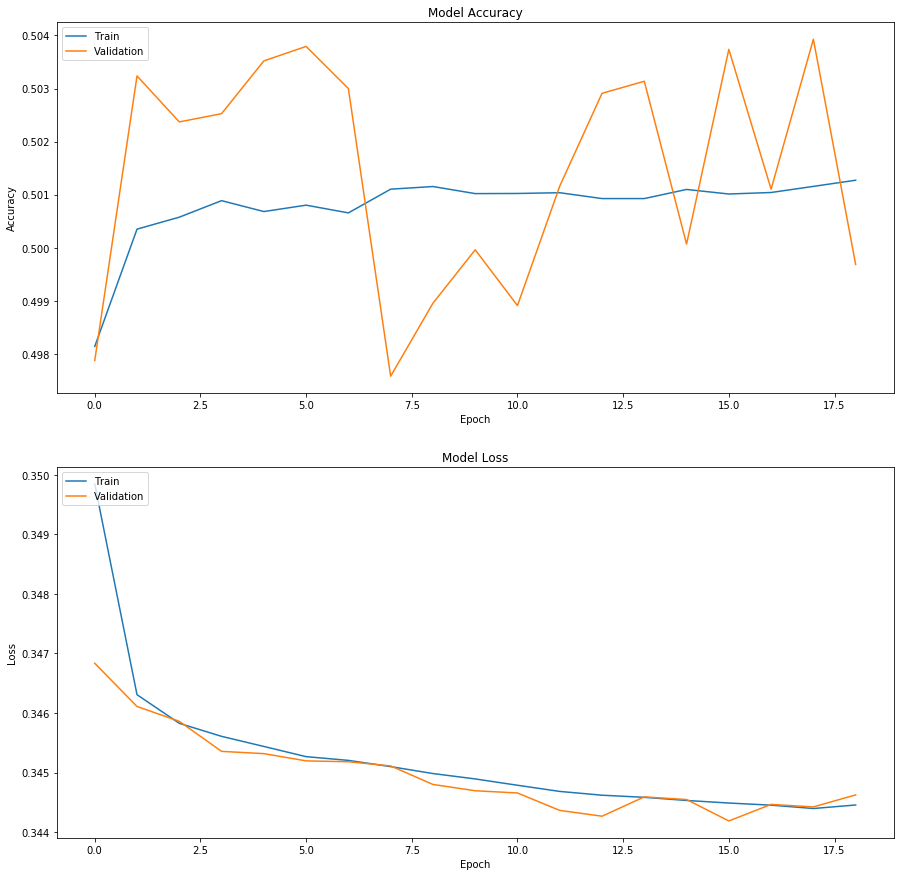

In [26]:
train_hist_plot(final3_history, "model_final3_train_perf")

In [27]:
model_metrics(model_final3, X_test_scaled, y_test)

[[156157  20756   5335      0   2224   7252]
 [  6827  64406   9898      0   1699   6826]
 [ 17191  24548  25863      0   2492  22479]
 [  3652  10637   9163      0   1032   9671]
 [ 26542  11410  10411      0   3285   9338]
 [  8664  18044  16471      0   2097  17981]]
AUC: 0.7824483357718477
532351/532351 [==============================] - 5s 9us/step
Test score: 0.34437999444079165
Test accuracy: 0.502848684421401


## Model 4

In [28]:
# Instatiate a Sequential model
model_final4 = Sequential()

# Create a basic network
model_final4.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final4.add(Dense(50, activation = 'tanh'))
model_final4.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [29]:
final4_checkpoint_path, final4_history = fit_save_model(model_final4, 'model_final4', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 33s 28us/step - loss: 0.3473 - categorical_accuracy: 0.4982 - val_loss: 0.3453 - val_categorical_accuracy: 0.5006

Epoch 00001: val_loss improved from inf to 0.34526, saving model to model_final/model_final4.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 33s 27us/step - loss: 0.3450 - categorical_accuracy: 0.5004 - val_loss: 0.3449 - val_categorical_accuracy: 0.5009

Epoch 00002: val_loss improved from 0.34526 to 0.34490, saving model to model_final/model_final4.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3446 - categorical_accuracy: 0.5008 - val_loss: 0.3445 - val_categorical_accuracy: 0.5033

Epoch 00003: val_loss improved from 0.34490 to 0.34447, saving model to model_final/model_final4.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 30s 25us/step - loss: 0.3445 - categorical_accuracy:

In [30]:
# Load best model to save training time
model_final4 = keras.models.load_model(final4_checkpoint_path)

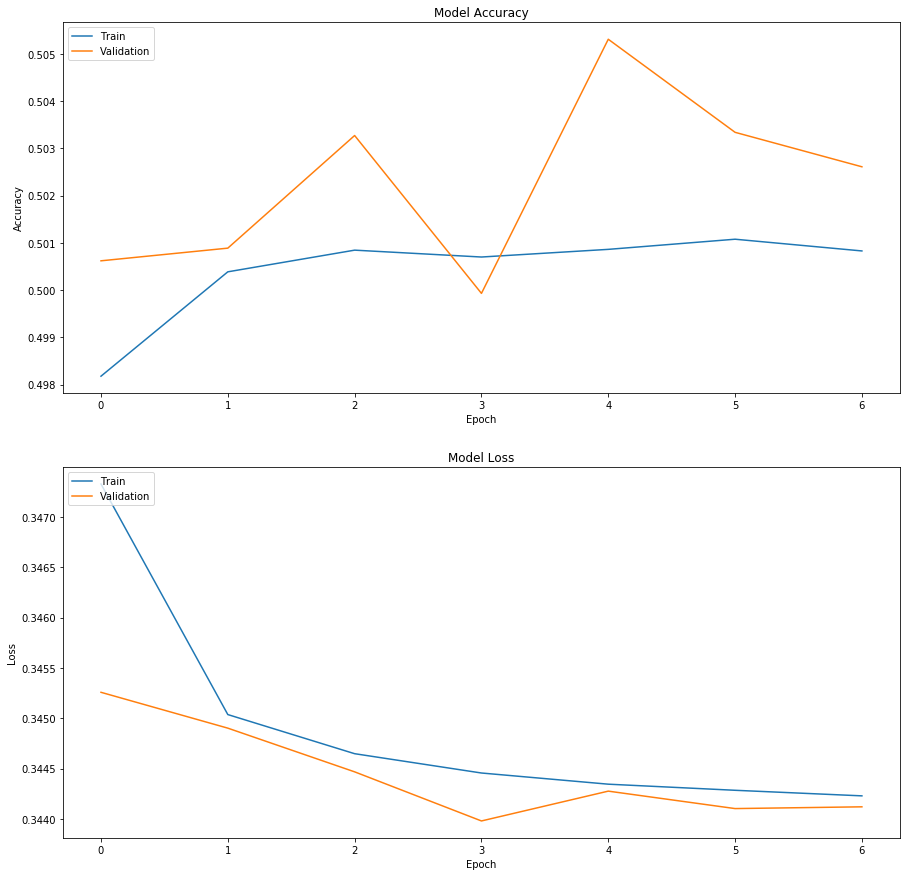

In [31]:
train_hist_plot(final4_history, "model_final4_train_perf")

In [32]:
model_metrics(model_final4, X_test_scaled, y_test)

[[156492  20385   4258      0   2913   7676]
 [  7407  63595   8367      0   2227   8060]
 [ 17220  24417  20391      0   2759  27786]
 [  3694  10419   7159      0   1119  11764]
 [ 26091  11490   8527      0   3818  11060]
 [  8702  17778  12967      0   2278  21532]]
AUC: 0.7826625428046555
532351/532351 [==============================] - 5s 9us/step
Test score: 0.34420247485990263
Test accuracy: 0.49934723518959717


## Model 5

In [33]:
# Instatiate a Sequential model
model_final5 = Sequential()

# Create a basic network
model_final5.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final5.add(Dense(50, activation = 'tanh'))
model_final5.add(Dense(50, activation = 'elu'))
model_final5.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [34]:
final5_checkpoint_path, final5_history = fit_save_model(model_final5, 'model_final5', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3473 - categorical_accuracy: 0.4982 - val_loss: 0.3454 - val_categorical_accuracy: 0.5062

Epoch 00001: val_loss improved from inf to 0.34542, saving model to model_final/model_final5.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3450 - categorical_accuracy: 0.5002 - val_loss: 0.3449 - val_categorical_accuracy: 0.4962

Epoch 00002: val_loss improved from 0.34542 to 0.34486, saving model to model_final/model_final5.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3446 - categorical_accuracy: 0.5004 - val_loss: 0.3446 - val_categorical_accuracy: 0.5029

Epoch 00003: val_loss improved from 0.34486 to 0.34460, saving model to model_final/model_final5.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 37s 31us/step - loss: 0.3444 - categorical_accuracy:

In [35]:
# Load best model to save training time
model_final5 = keras.models.load_model(final5_checkpoint_path)

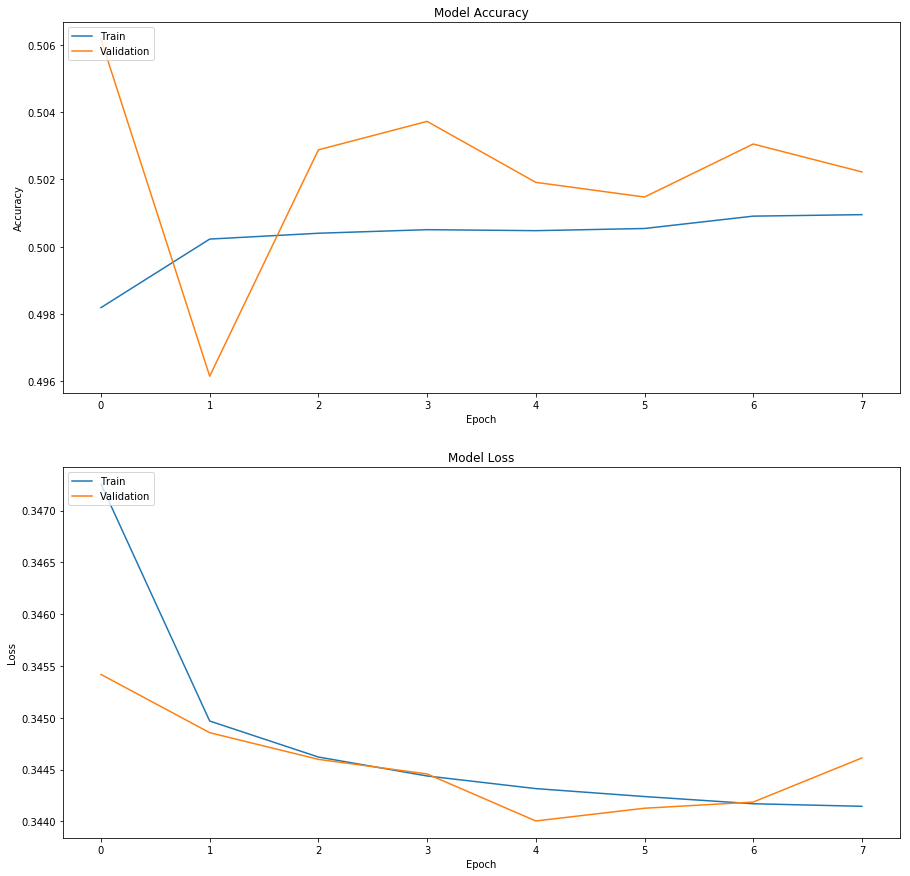

In [36]:
train_hist_plot(final5_history, "model_final5_train_perf")

In [37]:
model_metrics(model_final5, X_test_scaled, y_test)

[[158139  19072   5759      0   1333   7421]
 [  8669  61259  12062      0    785   6881]
 [ 18487  21937  26867      0   1342  23940]
 [  4180   9483  10018      0    528   9946]
 [ 27439  10746  11128      0   1899   9774]
 [  9632  16122  17807      0   1148  18548]]
AUC: 0.7829955824905536
532351/532351 [==============================] - 6s 12us/step
Test score: 0.34425080315667445
Test accuracy: 0.5010077937308604


## Model 6

In [38]:
# Instatiate a Sequential model
model_final6 = Sequential()

# Create a basic network
model_final6.add(Dense(25, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final6.add(Dense(25, activation = 'tanh'))
model_final6.add(Dense(25, activation = 'elu'))
model_final6.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final6.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [39]:
final6_checkpoint_path, final6_history = fit_save_model(model_final6, 'model_final6', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 35s 30us/step - loss: 0.3479 - categorical_accuracy: 0.4976 - val_loss: 0.3458 - val_categorical_accuracy: 0.4916

Epoch 00001: val_loss improved from inf to 0.34584, saving model to model_final/model_final6.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3451 - categorical_accuracy: 0.5001 - val_loss: 0.3445 - val_categorical_accuracy: 0.5006

Epoch 00002: val_loss improved from 0.34584 to 0.34455, saving model to model_final/model_final6.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 35s 29us/step - loss: 0.3447 - categorical_accuracy: 0.5003 - val_loss: 0.3446 - val_categorical_accuracy: 0.4984

Epoch 00003: val_loss did not improve from 0.34455
Epoch 4/25
1197789/1197789 [==============================] - 36s 30us/step - loss: 0.3446 - categorical_accuracy: 0.5006 - val_loss: 0.3453 - val_categorical_accura

In [40]:
# Load best model to save training time
model_final6 = keras.models.load_model(final6_checkpoint_path)

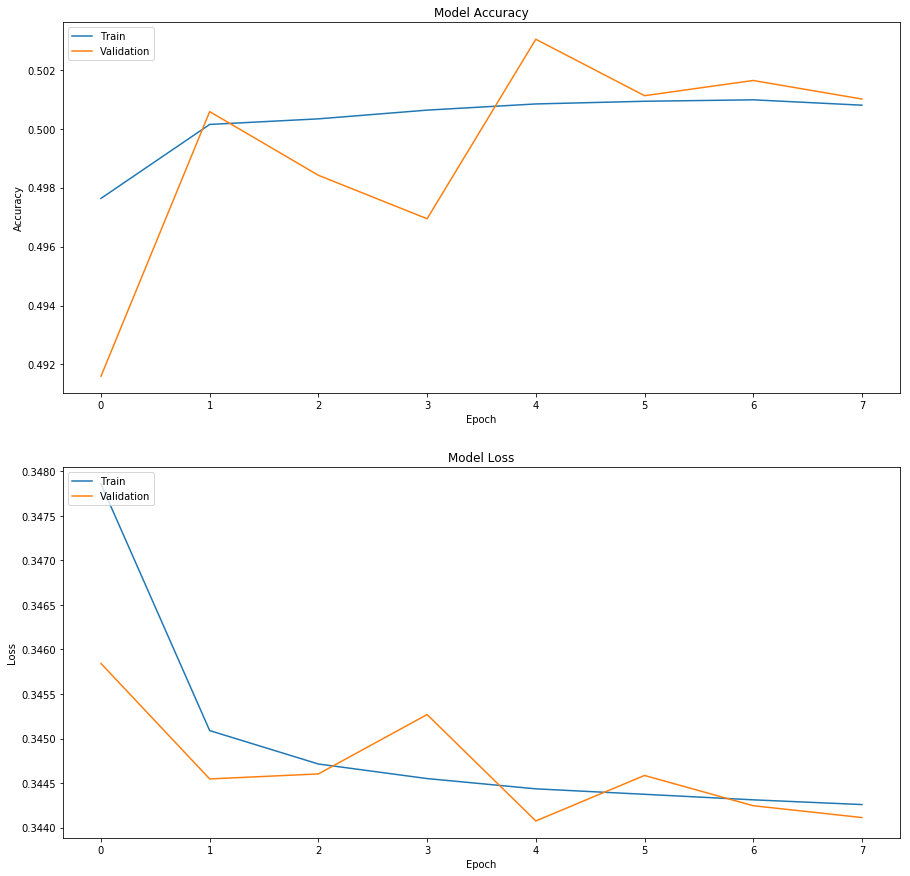

In [41]:
train_hist_plot(final6_history, "model_final6_train_perf")

In [42]:
model_metrics(model_final6, X_test_scaled, y_test)

[[156962  19307   6419      0   2182   6854]
 [  7992  60809  13251      0   1624   5980]
 [ 17473  21724  30181      0   2434  20761]
 [  3833   9277  11097      0    979   8969]
 [ 26745  10315  12094      0   3181   8651]
 [  8938  15912  19869      0   1992  16546]]
AUC: 0.7827107226661703
532351/532351 [==============================] - 6s 12us/step
Test score: 0.34427431683556503
Test accuracy: 0.502824264442853


## Model 7

In [43]:
# Instatiate a Sequential model
model_final7 = Sequential()

# Create a basic network
model_final7.add(Dense(300, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_final7.add(Dropout(0.2))
model_final7.add(Dense(100, activation = 'elu'))
model_final7.add(Dropout(0.2))
model_final7.add(Dense(100, activation = 'elu'))
model_final7.add(Dropout(0.2))
model_final7.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final7.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [44]:
final7_checkpoint_path, final7_history = fit_save_model(model_final7, 'model_final7', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 95s 79us/step - loss: 0.3537 - categorical_accuracy: 0.4931 - val_loss: 0.3502 - val_categorical_accuracy: 0.4957

Epoch 00001: val_loss improved from inf to 0.35022, saving model to model_final/model_final7.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 93s 77us/step - loss: 0.3511 - categorical_accuracy: 0.4949 - val_loss: 0.3470 - val_categorical_accuracy: 0.4959

Epoch 00002: val_loss improved from 0.35022 to 0.34701, saving model to model_final/model_final7.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 93s 77us/step - loss: 0.3508 - categorical_accuracy: 0.4951 - val_loss: 0.3467 - val_categorical_accuracy: 0.4969

Epoch 00003: val_loss improved from 0.34701 to 0.34673, saving model to model_final/model_final7.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 93s 78us/step - loss: 0.3508 - categorical_accuracy:

In [45]:
# Load best model to save training time
model_final7 = keras.models.load_model(final7_checkpoint_path)

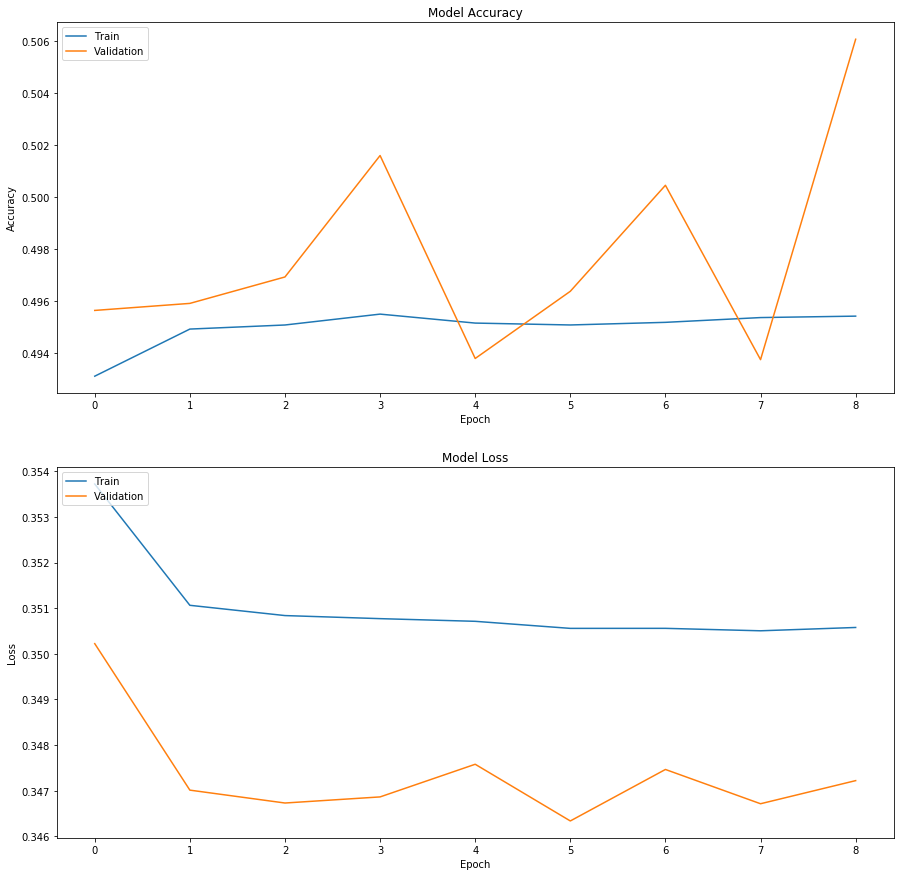

In [46]:
train_hist_plot(final7_history, "model_final7_train_perf")

In [47]:
model_metrics(model_final7, X_test_scaled, y_test)

[[161288  15959   7261      0    587   6629]
 [ 11876  56699  12346      0    574   8161]
 [ 19654  19882  21879      0    641  30517]
 [  4629   8670   7828      0    236  12792]
 [ 28566   9231  10150      0   1025  12014]
 [ 10539  14601  14455      0    475  23187]]
AUC: 0.7799042006698205
532351/532351 [==============================] - 11s 20us/step
Test score: 0.3465406760147892
Test accuracy: 0.4960599303850603


## Model 8

In [48]:
# Instatiate a Sequential model
model_final8 = Sequential()

# Create a basic network
model_final8.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final8.add(Dropout(0.2))
model_final8.add(Dense(50, activation = 'tanh'))
model_final8.add(Dropout(0.2))
model_final8.add(Dense(50, activation= 'elu'))
model_final8.add(Dropout(0.2))
model_final8.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final8.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [49]:
final8_checkpoint_path, final8_history = fit_save_model(model_final8, 'model_final8', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 53s 44us/step - loss: 0.3540 - categorical_accuracy: 0.4935 - val_loss: 0.3463 - val_categorical_accuracy: 0.4959

Epoch 00001: val_loss improved from inf to 0.34634, saving model to model_final/model_final8.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3498 - categorical_accuracy: 0.4957 - val_loss: 0.3464 - val_categorical_accuracy: 0.5035

Epoch 00002: val_loss did not improve from 0.34634
Epoch 3/25
1197789/1197789 [==============================] - 51s 43us/step - loss: 0.3493 - categorical_accuracy: 0.4965 - val_loss: 0.3455 - val_categorical_accuracy: 0.4969

Epoch 00003: val_loss improved from 0.34634 to 0.34552, saving model to model_final/model_final8.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3491 - categorical_accuracy: 0.4960 - val_loss: 0.3450 - val_categorical_accura

In [50]:
# Load best model to save training time
model_final8 = keras.models.load_model(final8_checkpoint_path)

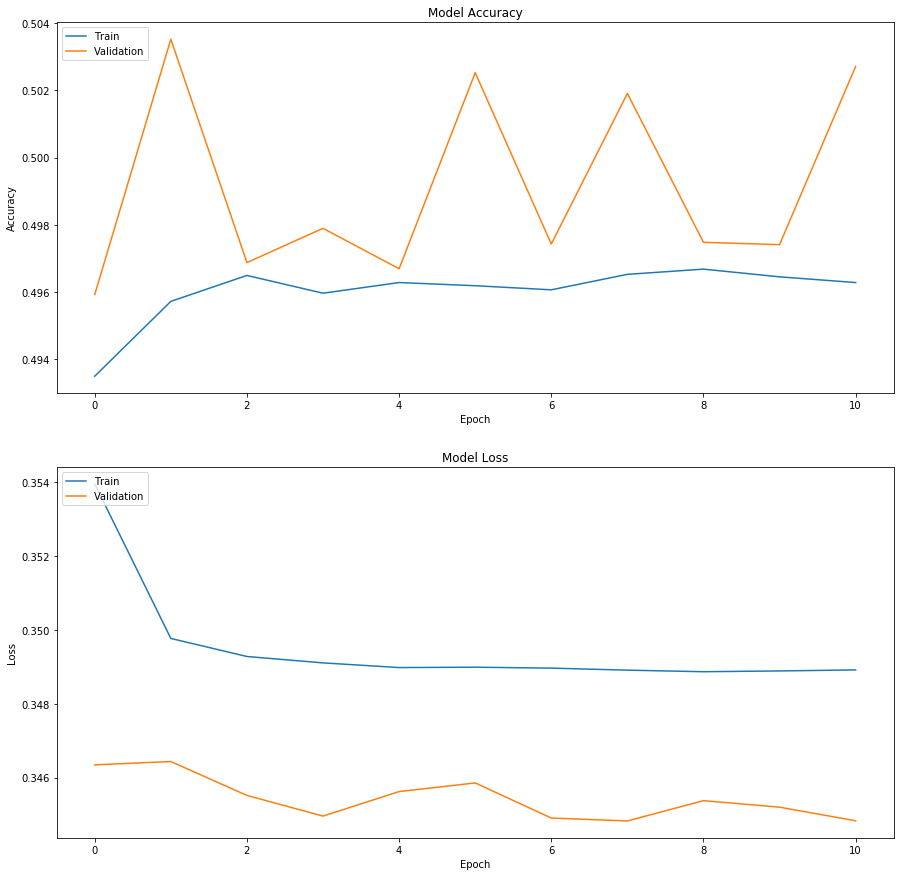

In [51]:
train_hist_plot(final8_history, "model_final8_train_perf")

In [52]:
model_metrics(model_final8, X_test_scaled, y_test)

[[155623  20879   5896      0   2146   7180]
 [  6530  62713  12423      0   1611   6379]
 [ 16911  22868  27595      0   2376  22823]
 [  3560   9837  10379      0    985   9394]
 [ 25939  11369  11091      0   3163   9424]
 [  8423  16837  18484      0   1962  17551]]
AUC: 0.7816464194783928
532351/532351 [==============================] - 9s 16us/step
Test score: 0.34501021163414075
Test accuracy: 0.5008819369183438


## Model 9

In [53]:
# Instatiate a Sequential model
model_final9 = Sequential()

# Create a basic network
model_final9.add(Dense(50, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model_final9.add(Dropout(0.3))
model_final9.add(Dense(50, activation = 'tanh'))
model_final9.add(Dropout(0.3))
model_final9.add(Dense(50, activation = 'elu'))
model_final9.add(Dropout(0.3))
model_final9.add(Dense(25, activation = 'elu'))
model_final9.add(Dropout(0.3))
model_final9.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_final9.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [54]:
final9_checkpoint_path, final9_history = fit_save_model(model_final9, 'model_final9', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 60s 50us/step - loss: 0.3605 - categorical_accuracy: 0.4858 - val_loss: 0.3472 - val_categorical_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.34723, saving model to model_final/model_final9.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 58s 49us/step - loss: 0.3547 - categorical_accuracy: 0.4915 - val_loss: 0.3468 - val_categorical_accuracy: 0.4975

Epoch 00002: val_loss improved from 0.34723 to 0.34678, saving model to model_final/model_final9.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 59s 49us/step - loss: 0.3540 - categorical_accuracy: 0.4917 - val_loss: 0.3466 - val_categorical_accuracy: 0.4956

Epoch 00003: val_loss improved from 0.34678 to 0.34659, saving model to model_final/model_final9.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 59s 49us/step - loss: 0.3539 - categorical_accuracy:

In [55]:
# Load best model to save training time
model_final9 = keras.models.load_model(final9_checkpoint_path)

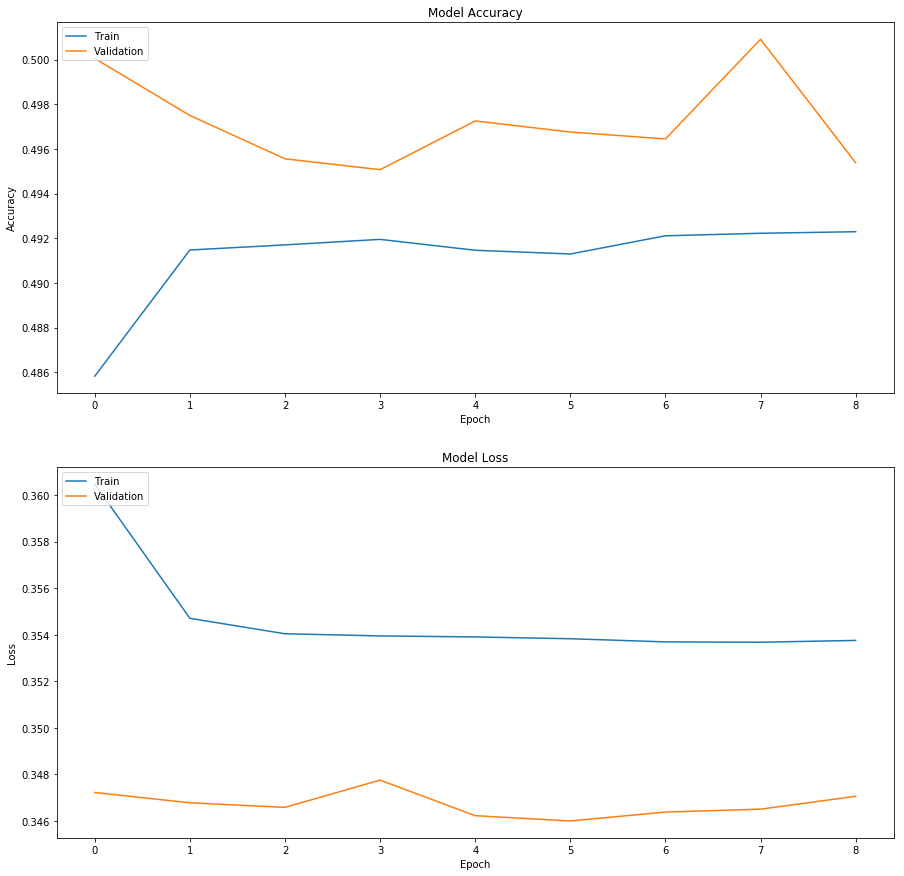

In [56]:
train_hist_plot(final9_history, "model_final9_train_perf")

In [57]:
model_metrics(model_final9, X_test_scaled, y_test)

[[156416  20422   6691      0    935   7260]
 [  7086  64029  10652      0    524   7365]
 [ 17472  24576  20286      0    875  29364]
 [  3777  10579   7500      0    338  11961]
 [ 27249  11353   9349      0   1249  11786]
 [  8915  17879  13876      0    726  21861]]
AUC: 0.7787865631882337
532351/532351 [==============================] - 8s 15us/step
Test score: 0.34618077446923223
Test accuracy: 0.4956147353898521


## Model 10

In [78]:
# Instatiate a Sequential model
model_finalX = Sequential()

# Create a basic network
model_finalX.add(Dense(150, activation = 'elu', input_shape = (X_train_scaled.shape[1],)))
model_finalX.add(Dropout(0.5))
model_finalX.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_finalX.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [79]:
finalX_checkpoint_path, finalX_history = fit_save_model(model_finalX, 'model_finalX', X_train_scaled, y_train)

Train on 1197789 samples, validate on 399263 samples
Epoch 1/25
1197789/1197789 [==============================] - 59s 49us/step - loss: 0.3570 - categorical_accuracy: 0.4925 - val_loss: 0.3484 - val_categorical_accuracy: 0.4989

Epoch 00001: val_loss improved from inf to 0.34838, saving model to model_final/model_finalX.hdf5
Epoch 2/25
1197789/1197789 [==============================] - 57s 47us/step - loss: 0.3521 - categorical_accuracy: 0.4950 - val_loss: 0.3483 - val_categorical_accuracy: 0.5020

Epoch 00002: val_loss improved from 0.34838 to 0.34828, saving model to model_final/model_finalX.hdf5
Epoch 3/25
1197789/1197789 [==============================] - 57s 48us/step - loss: 0.3518 - categorical_accuracy: 0.4954 - val_loss: 0.3476 - val_categorical_accuracy: 0.4980

Epoch 00003: val_loss improved from 0.34828 to 0.34765, saving model to model_final/model_finalX.hdf5
Epoch 4/25
1197789/1197789 [==============================] - 57s 47us/step - loss: 0.3516 - categorical_accuracy:

In [80]:
# Load best model to save training time
model_finalX = keras.models.load_model(finalX_checkpoint_path)

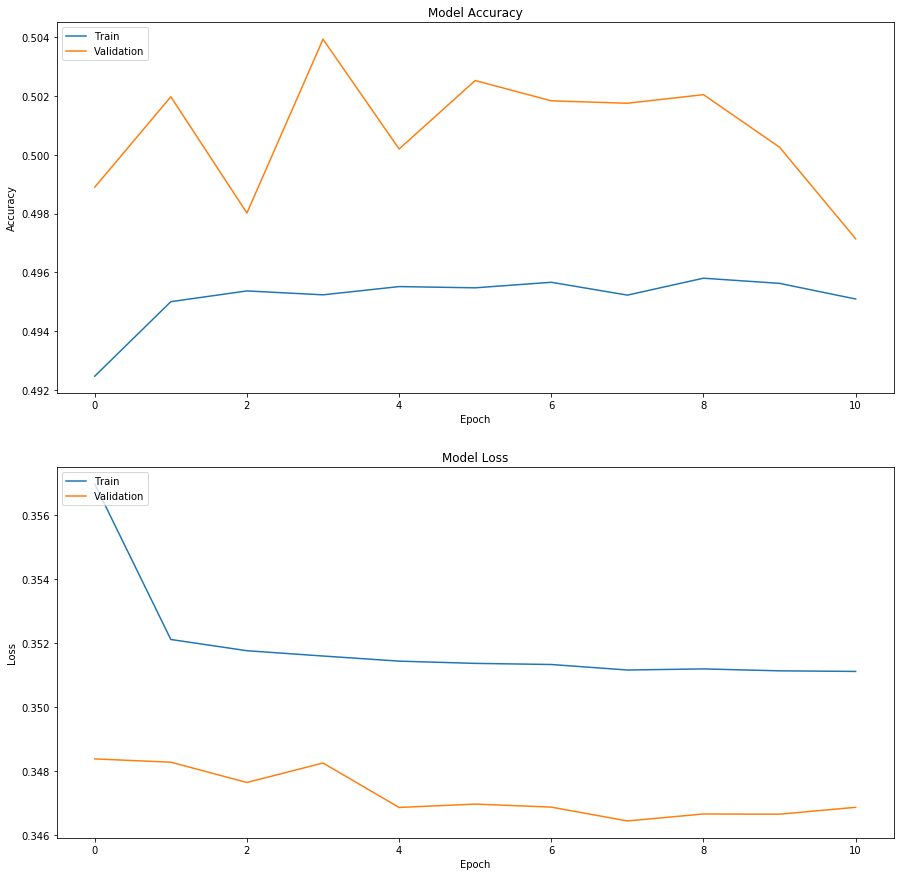

In [81]:
train_hist_plot(finalX_history, "model_finalX_train_perf")

In [82]:
model_metrics(model_finalX, X_test_scaled, y_test)

[[158222  19016   5978      0   1055   7453]
 [  8815  61869  11127      0    619   7226]
 [ 18072  23709  27109      0    905  22778]
 [  3983  10136   9822      0    353   9861]
 [ 27472  11234  11204      0   1292   9784]
 [  9338  17323  17598      0    733  18265]]
AUC: 0.7788616139382484
532351/532351 [==============================] - 9s 17us/step
Test score: 0.34662775664374035
Test accuracy: 0.5010923244258342
